## Predicting porphyry Cu fertility using whole-rock geochemistry

This Jupyter notebook is a coding demonstration showing how to construct a simple, supervised machine learning model using Python's scikit-learn package. For simplicity, the datasets are mostly already cleaned up, and the focus here is building the model, followed by an introduction to model explainability.

If you have any questions or requests, you can contact me at cln14@ic.ac.uk, you can find the full paper related to this work at the following link: https://doi.org/10.1007/s00126-021-01086-9. Please do cite the article if you use this in your work.

### Import packages and define any functions

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import decomposition
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn import preprocessing
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.utils import resample
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

# This function calculates the centred log ratio transformation of a compositional dataset
def clr(compositional_data):
    # the geometric mean acts as the center of the composition    
    geom_mean = np.power(np.prod(compositional_data,axis=1),1/len(compositional_data.columns))
    return np.log(compositional_data.div(geom_mean,axis=0))


### Import data

First, we can import the datasets and prepare them:

In [9]:
# Import data
porphyry_WR = pd.read_csv("220517_DataExport.csv",  encoding= 'unicode_escape' )
GEOROC_WR = pd.read_csv("all_GEOROC_data_processed.csv")

# Centred log ratio transformation
porphyry_WR_clr = clr(porphyry_WR.iloc[:,4:])
GEOROC_WR_clr = clr(GEOROC_WR)

# Join datasets
x = pd.concat([porphyry_WR_clr, GEOROC_WR_clr], axis = 0)
y = porphyry_WR['Fertility']
y = np.pad(y, (0, len(GEOROC_WR)), 'constant')
x['Fertility'] = y
x = x.dropna(inplace=False)
y = x['Fertility']
x = x.drop('Fertility', axis = 1)

### Initiate classification models

We will now initiate four machine learning models. The "hyperparameters" were tuned using a grid search approach. I would recommend reading the theory behind each classifier (I have summarised each one in the paper) and the assumptions behind them. The scikit-learn documentation is excellent for learning more.

In [10]:
# Set classifiers
MLPclassifier = MLPClassifier(hidden_layer_sizes= (75,25), max_iter= 500, solver= 'adam', random_state = 100, activation = 'tanh')
SVMclassifier  = svm.SVC(kernel='rbf', probability = True, C = 9, random_state = 100, gamma = 'auto') # Linear Kernel
LogRegclassifier= LogisticRegression(solver = 'newton-cg', C = 10, random_state = 100)
RFclassifier  = RandomForestClassifier(n_estimators = 1000, min_samples_split = 2, min_samples_leaf = 1,
                                    max_features = 'auto',max_depth = 50, bootstrap = True, random_state = 100)
classifiers = [MLPclassifier, SVMclassifier, LogRegclassifier, RFclassifier]

# PCA - we want to set up PCA so that it only includes PCs that account for 95% of the variability in the dataset
pca_sk = PCA()
WR_all_pca = pca_sk.fit_transform(x)
total_explained_variance = pca_sk.explained_variance_ratio_.cumsum()
n_over_90 = len(total_explained_variance[total_explained_variance >= .90])
n_to_reach_90 = x.shape[1] - n_over_90 + 1
print("Number features: {}\tTotal Variance Explained: {}".format(n_to_reach_90, total_explained_variance[n_to_reach_90-1]))
print(n_to_reach_90)

Number features: 6	Total Variance Explained: 0.9202701500302225
6


### Validating the models and evaluating performance

We will now have a go at a 10-fold cross validation, where we split the training set into 10 "folds", train with 9 folds, validate with 1 and then repeat 9 times until each fold has been used to validate the model. We will visualise our models using ROC-AUC curves, where the AUC indicates the probability of the model ranking a randomly selected fertile composition higher than a randomly selected unfertile composition.

C:\Users\chen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
C:\Users\chen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
C:\Users\chen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
C:\Users\chen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn

NameError: name 'metrics' is not defined

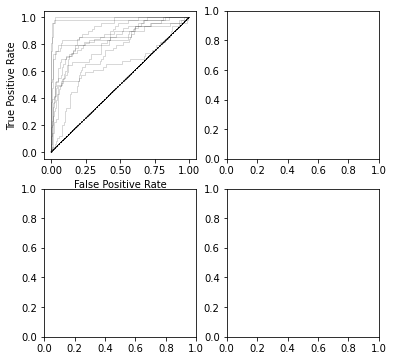

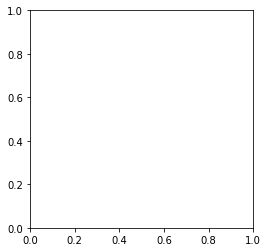

In [11]:
from sklearn.model_selection import StratifiedKFold
from pylab import rcParams

rcParams['figure.figsize'] = 6,6
fig, axs = plt.subplots(2,2)
axr = axs.ravel()
cv = StratifiedKFold(n_splits=10,shuffle=False)

fig2, ax = plt.subplots(1,1, figsize = [4,4])

# Calculate ROC curves for each algorithm for each fold in 10 fold cv
mean_fpr = np.linspace(0,1,100)
aucs = []
tprs = []
all_tpr = []
all_fpr = []
all_auc = []
i = 1
j = 0
names = ['ANN','SVM','LR','RF']
axis_index = [[0,0],[0,1],[1,0]]
for classifier in classifiers:
    mean_fpr = np.linspace(0,1,100)
    aucs = []
    tprs = []
    i = 1
    for train, test in cv.split(x, y):
#         pipe = Pipeline(steps=[('preprocessor', preprocessor),('pca_sk', PCA(n_components=n_to_reach_95)),('classifier', classifier)])
        pipe = Pipeline(steps=[('pca_sk', PCA(n_components=n_to_reach_90)),('classifier', classifier)])
        y_probs = pipe.fit(x.iloc[train], y.iloc[train]).predict_proba(x.iloc[test])
        fpr, tpr, thresholds = roc_curve(y.iloc[test], y_probs[:,1])
        auc_value = roc_auc_score(y.iloc[test], y_probs[:,1])
        aucs.append(auc_value)
        tprs.append(np.interp(mean_fpr,fpr,tpr))
        axr[j].plot(fpr, tpr, lw = 0.5, alpha = 0.3,color = 'black', label='ROC fold %d (AUC = %0.2f)' % (i, auc_value))
        axr[j].plot([0,1],[0,1],linestyle = '--',lw = 0.5,color = 'black')
        axr[j].set_xlabel('False Positive Rate')
        axr[j].set_ylabel('True Positive Rate')
        i = i + 1
    mean_tpr = np.mean(tprs, axis = 0)
    mean_auc = metrics.auc(mean_fpr, mean_tpr)
    all_tpr.append(mean_tpr)
    all_fpr.append(mean_fpr)
    all_auc.append(mean_auc)
    axr[j].plot(mean_fpr, mean_tpr)
    ax.plot(mean_fpr, mean_tpr)
    axr[j].text(0.4,0, 'Mean AUC = %0.2f' % (mean_auc), bbox=dict(facecolor='none', edgecolor='black'))
    j = j + 1

axr[0].set_title('Support Vector Machine')
axr[1].set_title('Artificial Neural Network')
axr[2].set_title('Logistic Regression')
axr[3].set_title('Random Forest')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
fig.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
# fig.show()
# fig.savefig('ROC_CV.svg', dpi = 1200)
fig2.show()


### Testing the models

We now can have a go at testing these models with data unseen during the training process. First, we can try with data from Quellaveco porphyry Cu-Mo deposit in South Peru, data from https://doi.org/10.1007/s00410-020-01766-1

C:\Users\chen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


    unfertile   fertile
0    0.485719  0.514281
1    0.998479  0.001521
2    0.004754  0.995246
3    0.000848  0.999152
4    0.018777  0.981223
..        ...       ...
66   0.909776  0.090224
67   0.985078  0.014922
68   0.983199  0.016801
69   0.999614  0.000386
70   0.988099  0.011901

[71 rows x 2 columns]
    unfertile   fertile
0    0.943085  0.056915
1    0.920008  0.079992
2    0.368437  0.631563
3    0.141109  0.858891
4    0.043432  0.956568
..        ...       ...
66   0.835882  0.164118
67   0.966303  0.033697
68   0.970812  0.029188
69   0.950348  0.049652
70   0.917753  0.082247

[71 rows x 2 columns]
    unfertile   fertile
0    0.898337  0.101663
1    0.975218  0.024782
2    0.564767  0.435233
3    0.444565  0.555435
4    0.411757  0.588243
..        ...       ...
66   0.941299  0.058701
67   0.968575  0.031425
68   0.963705  0.036295
69   0.988249  0.011751
70   0.994616  0.005384

[71 rows x 2 columns]
    unfertile  fertile
0       0.897    0.103
1       0.885    0.11

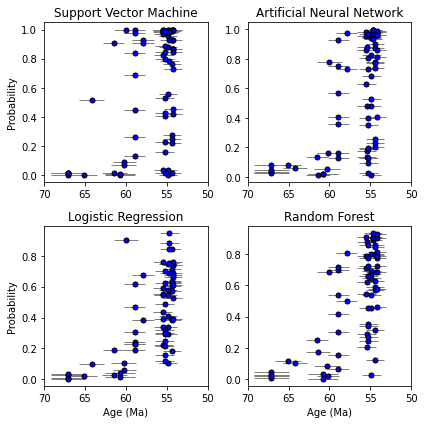

In [14]:
# We will need to convert oxides to elements, let's define the conversion factors
import periodictable as pt
conversion = [pt.formula("Si").mass/pt.formula("SiO2").mass,
              pt.formula("Al").mass/pt.formula("Al2O3").mass,
              pt.formula("Fe").mass/pt.formula("FeO").mass,
              pt.formula("Mg").mass/pt.formula("MgO").mass,
              pt.formula("Ca").mass/pt.formula("CaO").mass,
              pt.formula("Na").mass/pt.formula("Na2O").mass,
              pt.formula("K").mass/pt.formula("K2O").mass,
              pt.formula("Ti").mass/pt.formula("Ti2O").mass,
              pt.formula("Mn").mass/pt.formula("MnO").mass]


qvc = pd.read_csv('Quellaveco_WR_Age.csv')
qvc_info = qvc[['U-Pb Age (Ma)', 'Uncertainty (Ma)']]

qvc = qvc[['SiO2', 'Al2O3','Fe2O3','MgO', 'CaO','Na2O','K2O','TiO2','MnO','Sr_ppm','Y_ppm',
           'La_ppm', 'Ce_ppm', 'Pr_ppm', 'Nd_ppm', 'Sm_ppm', 
           'Eu_ppm','Gd_ppm', 'Tb_ppm','Dy_ppm', 'Ho_ppm',
           'Er_ppm', 'Tm_ppm', 'Yb_ppm', 'Lu_ppm']]



qvc['Fe2O3'] = qvc['Fe2O3']*0.8998 # Convert to FEO
qvc = qvc.apply(pd.to_numeric, errors='coerce')
qvc.iloc[:,:9] =qvc.iloc[:,:9]*10000
qvc.iloc[:,:9] = qvc.iloc[:,:9].multiply(conversion, axis = 1)

qvc = pd.DataFrame(clr(qvc), columns = qvc.columns)
qvc = qvc.replace([np.inf, -np.inf], np.nan) # drop any inf values
qvc = qvc.dropna()

qvc.columns = ['Si', 'Al', 'Fe', 'Mg', 'Ca', 'Na','K', 'Ti', 'Mn', 'Sr', 'Y', 
                  'La', 'Ce','Pr', 'Nd', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er',
                  'Tm', 'Yb', 'Lu']

fig, axs = plt.subplots(2,2)
axr = axs.ravel()
n = 0

# For each classifier, a plot of time versus probability is shown
# At Quellaveco, we expect the porphyries (~55 Ma) to have the highest probabilities
# There should be a trend towards higher probabilities over time
for classifier in classifiers:
        pipe = Pipeline(steps=[('pca_sk', PCA(n_components=n_to_reach_90)),('classifier', classifier)])
        y_probs = pd.DataFrame(pipe.fit(x, y).predict_proba(qvc), columns = ['unfertile', 'fertile'])
        print(y_probs)
        axr[n].errorbar(x = qvc_info['U-Pb Age (Ma)'], y = y_probs['fertile'],
                        xerr = qvc_info['Uncertainty (Ma)'], fmt='o', 
                        ecolor = 'gray',mec = 'black', lw = 1,ms = 5, color = 'blue')
        axr[n].set_xlim(70, 50)
        n = n + 1
        
axr[0].set_title('Support Vector Machine')
axr[1].set_title('Artificial Neural Network')
axr[2].set_title('Logistic Regression')
axr[3].set_title('Random Forest')

axr[0].set_ylabel('Probability')
axr[2].set_ylabel('Probability')

axr[2].set_xlabel('Age (Ma)')
axr[3].set_xlabel('Age (Ma)')

fig.tight_layout()
plt.show()

From looking at these results, there are a number of false negatives in the porphyry rocks. It looks like Random Forest is the best performer here, and SVM the worst. Now let's do some further testing, using additional data from the Chipispaya and Corcapunta porphyry prospects in Peru, and unfertile rocks from the Coastal Cordillera, Chile.

In [64]:
# Import and pre-process the data
val_data = pd.read_csv('200817_Validation_WR_Data.csv') # qvc, chp, corcp
val_y = val_data[['Fertility']]


val_data = val_data[['Deposit','SiO2', 'Al2O3','Fe2O3','MgO', 'CaO','Na2O','K2O','TiO2','MnO','Sr','Y',
                     'La', 'Ce', 'Pr', 'Nd', 'Sm', 'Eu','Gd', 'Tb','Dy', 'Ho','Er', 'Tm', 'Yb', 'Lu']]

val_data['Fe2O3'] = val_data['Fe2O3']*0.8998 # Convert to FEO
# Make binary labels
val_data.iloc[:,1:] = val_data.iloc[:,1:].apply(pd.to_numeric, errors='coerce')
val_data.iloc[:,1:8] =val_data.iloc[:,1:8]*10000
val_data.iloc[:,1:10] = val_data.iloc[:,1:10].multiply(conversion, axis = 1)
val_data.iloc[:,1:] = val_data.iloc[:,1:].apply(pd.to_numeric, errors='coerce').fillna(0.1, downcast='infer')

val_data_REEs = val_data.iloc[:,12:]
val_data.iloc[:,1:] = pd.DataFrame(clr(val_data.iloc[:,1:]), columns = val_data.iloc[:,1:].columns)
val_data['Fertility'] = 1
val_data.rename(columns = {'SiO2':'Si', 'Al2O3':'Al','Fe2O3':'Fe', 'MgO': 'Mg','CaO':'Ca', 'Na2O':'Na','K2O':'K','TiO2':'Ti', 'MnO':'Mn'},
                inplace = True)


In [65]:
val_data_unfertile = pd.read_csv('Val_Data_Export.csv')
val_data_unfertile['Fertility'] = 0
val_data_unfertile.rename(columns = {'SiO2':'Si', 'Al2O3':'Al','Fe2O3':'Fe', 'MgO': 'Mg','CaO':'Ca', 'Na2O':'Na','K2O':'K','TiO2':'Ti', 'MnO':'Mn'},
                inplace = True)
val_data_all = []
# Split into separate
for name, group in val_data.groupby('Deposit'):
    for i in np.random.choice(len(val_data_unfertile),len(group)):
        group = pd.concat([group, val_data_unfertile.iloc[[i]]], axis = 0, ignore_index=True)
    val_data_all.append(group)

val_barren = []
for i in np.random.choice(len(val_data_unfertile), len(val_data)):
    val_barren.append(val_data_unfertile.iloc[i])
val_barren = pd.DataFrame(val_barren, columns = val_data.iloc[:,1:].columns)
val_barren.insert(0, 'Deposit', 'Unfertile')
val_barren = pd.concat([val_barren, val_data])
val_barren.rename(columns = {'SiO2':'Si', 'Al2O3':'Al','Fe2O3':'Fe', 'MgO': 'Mg','CaO':'Ca', 'Na2O':'Na','K2O':'K','TiO2':'Ti', 'MnO':'Mn'},
                inplace = True)

val_data_all.append(val_barren)

[       Deposit        Si        Al        Fe        Mg        Ca        Na  \
 0   Chipispaya  9.295812  7.349583  7.213559  6.970378  6.359288  6.835318   
 1   Chipispaya  9.183030  7.204976  6.419989  6.061090  6.975404  6.376975   
 2   Chipispaya  9.467539  7.357289  6.860287  5.848169  6.711190  6.586407   
 3   Chipispaya  9.389567  7.374492  7.269035  6.072064  6.613113  6.461098   
 4   Chipispaya  9.168197  7.132704  7.268917  5.745348  6.537141  6.212486   
 5   Chipispaya  9.445958  7.260251  7.685503  5.857948  6.426169  6.289689   
 6   Chipispaya  9.230766  7.235540  6.926161  5.811382  6.852223  6.150221   
 7   Chipispaya  9.400229  7.410922  7.156499  6.035423  7.051763  6.296364   
 8   Chipispaya  9.212928  7.306800  6.975043  6.424771  6.611797  6.703708   
 9   Chipispaya  9.104181  7.169339  7.151431  6.186024  6.672167  6.192312   
 10  Chipispaya  9.286617  7.366458  6.843295  6.289557  7.040971  6.858142   
 11  Chipispaya  9.162943  7.237364  6.808929  6.188

Now, as before we can make predictions from the test data and compare the outcomes...

C:\Users\chen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


AUC: 1.00 MLPClassifier(activation='tanh', hidden_layer_sizes=(75, 25), max_iter=500,
              random_state=100)
Accuracy = 0.8611111111111112
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0]
AUC: 0.58 SVC(C=9, gamma='auto', probability=True, random_state=100)
Accuracy = 0.3611111111111111
[0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 1 0 0 0 1 0 1 0 1 1 1 0 0 0 0]
AUC: 1.00 LogisticRegression(C=10, random_state=100, solver='newton-cg')
Accuracy = 0.9722222222222222
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
AUC: 0.94 RandomForestClassifier(max_depth=50, n_estimators=1000, random_state=100)
Accuracy = 0.8333333333333334
[1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 1 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0]


C:\Users\chen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


AUC: 1.00 MLPClassifier(activation='tanh', hidden_layer_sizes=(75, 25), max_iter=500,
              random_state=100)
Accuracy = 0.9333333333333333
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0]
AUC: 0.79 SVC(C=9, gamma='auto', probability=True, random_state=100)
Accuracy = 0.5
[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
AUC: 1.00 LogisticRegression(C=10, random_state=100, solver='newton-cg')
Accuracy = 0.9666666666666667
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
AUC: 0.92 RandomForestClassifier(max_depth=50, n_estimators=1000, random_state=100)
Accuracy = 0.8
[1 1 1 1 1 1 0 1 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]


C:\Users\chen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


AUC: 0.98 MLPClassifier(activation='tanh', hidden_layer_sizes=(75, 25), max_iter=500,
              random_state=100)
Accuracy = 0.8820224719101124
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 1 0 1 1 0 0 1 0
 1 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 0]
AUC: 0.76 SVC(C=9, gamma='auto', probability=True, random_state=100)
Accuracy = 0.43820224719101125
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0
 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0]
AUC: 1.00 LogisticRegression

C:\Users\chen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


AUC: 0.99 MLPClassifier(activation='tanh', hidden_layer_sizes=(75, 25), max_iter=500,
              random_state=100)
Accuracy = 0.9016393442622951
[0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 1 1 1 0 0 0 1 0 0 1 0 1 1 0 0 0 0 0 0 0
 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
AUC: 0.77 SVC(C=9, gamma='auto', probability=True, random_state=100)
Accuracy = 0.46311475409836067
[0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 

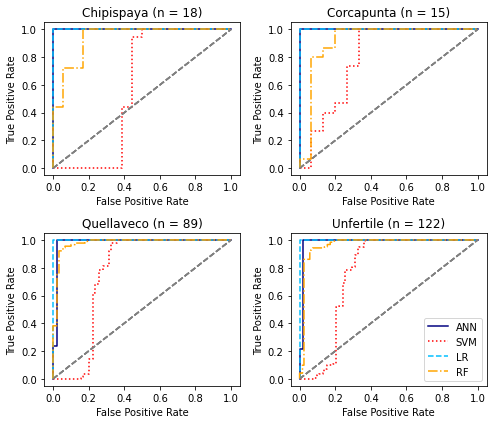

In [68]:
# Set up subplots
fig, axs = plt.subplots(2,2, figsize = (7,6))
axr = axs.ravel()
val_scores = []
rcParams['figure.figsize'] = 6,6
c = 0
colors = ['navy', 'red', 'deepskyblue','orange','#f781bf', '#a65628','#999999', '#e41a1c', '#dede00'] # line colours
lines = ['solid','dotted','dashed','dashdot']
for i in val_data_all:
    deposit = i['Deposit'].iloc[0]
    n = int(len(i)/2) # number of "fertile" samples to be classified
    val_data_y = i['Fertility']
    val_data_x = i.drop(['Fertility','Deposit'], axis = 1)
    j = 0
    for classifier in classifiers:
#         pipe = Pipeline(steps=[('preprocessor', preprocessor),('pca_sk', PCA(n_components=n_to_reach_95)),('classifier', classifier)])
        pipe = Pipeline(steps=[('pca_sk', PCA(n_components=n_to_reach_90)),('classifier', classifier)])
        y_probs = pipe.fit(x, y).predict_proba(val_data_x)
        fpr, tpr, thresholds = roc_curve(val_data_y, y_probs[:,1])
        y_pred = pipe.predict(val_data_x)
        auc = roc_auc_score(val_data_y,y_probs[:,1])
        accuracy = accuracy_score(val_data_y, y_pred, normalize = True)
        f1 = f1_score(val_data_y, y_pred)
        precision = precision_score(val_data_y, y_pred)
        recall = recall_score(val_data_y, y_pred)
        CM = confusion_matrix(val_data_y, y_pred)
        TN = CM[0][0]
        FN = CM[1][0]
        TP = CM[1][1]
        FP = CM[0][1]
        FPR = FP/(FP+TN)
        val_scores.append([accuracy,f1,precision,recall,auc,FPR])
        print('AUC: %.2f' % auc, classifier)
        print('Accuracy =', accuracy_score(val_data_y, y_pred, normalize = True))
        print(y_pred)
        fpr, tpr, thresholds = roc_curve(val_data_y,y_probs[:,1])
        # Now plot a ROC curve
        axr[c].plot(fpr, tpr, color= colors[j], label = names[j], alpha = 1, linestyle = lines[j])
        axr[c].plot([0, 1], [0, 1], color='grey', linestyle='--')
        axr[c].set_xlabel('False Positive Rate')
        axr[c].set_ylabel('True Positive Rate')
#         axr[c].legend(loc = 0)
        j = j + 1
    axr[c].set_title('%s (n = %d)' % (deposit, n))
    c = c + 1

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
fig.tight_layout()
# plt.show()


val_scores = pd.DataFrame(val_scores, columns = ['Accuracy','F1 Score','Precision','Recall','ROC-AUC','FPR'])
print(val_scores)

As before, the SVM model appears to perform weakest, whilst the other models appear to achieve reasonably high performance, suggesting the models have generalised the data well.

## Model explainability

There are various ways to interpret the most important discriminators of a supervised machine learning model. Two useful appraoches exist for the Random Forest algorithm:

1. Gini importance
2. Permutation importance

See the paper for more details on these approaches.

Si    0.041149
Al    0.046901
Fe    0.047909
Mg    0.042139
Ca    0.034644
Na    0.062302
K     0.072578
Ti    0.029442
Mn    0.065318
Sr    0.098883
Y     0.029262
La    0.025162
Ce    0.026557
Pr    0.027523
Nd    0.035597
Sm    0.028688
Eu    0.022522
Gd    0.034014
Tb    0.071222
Dy    0.036263
Ho    0.039252
Er    0.019627
Tm    0.019559
Yb    0.019997
Lu    0.023492
dtype: float64


C:\Users\chen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\chen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator


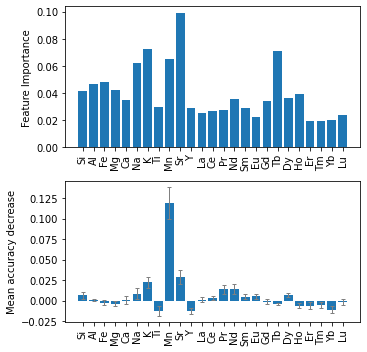

In [70]:
labels = ['Si', 'Al', 'Fe', 'Mg', 'Ca', 'Na','K', 'Ti', 'Mn', 'Sr', 'Y', 
                  'La', 'Ce','Pr', 'Nd', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er',
                  'Tm', 'Yb', 'Lu']

# Fit model to all data
RFclassifier.fit(x, y)

# Create a figure using out of bag data to show Gini importance
feature_imp = pd.Series(RFclassifier.feature_importances_,index = labels)
# Creating a bar plot

from sklearn.inspection import permutation_importance

# Now try permuting the validation dataset to evaluate the accuracy decrease when a feature is absent
result = permutation_importance(
    RFclassifier,val_data_x,val_data_y, n_repeats=20, random_state=1, n_jobs=2)

forest_importances = pd.Series(result.importances_mean, index=labels)

rcParams['figure.figsize'] = 5,5
fig, axs = plt.subplots(2,1)

axs[0].bar(x=feature_imp.index, height = feature_imp)
# Add labels to your graph
axs[0].set_ylabel('Feature Importance')
axs[0].set_xticklabels(labels = feature_imp.index, rotation = 90)
# axs[0].set_xticks(feature_imp.index)

# Bars with errors being standard deviations
axs[1].bar(x = forest_importances.index, height = forest_importances,
        yerr=result.importances_std,error_kw=dict(ecolor='gray', lw=1, capsize=2, capthick=1))
axs[1].set_xticklabels(labels = feature_imp.index, rotation = 90)
axs[1].set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
plt.show()